# Supernova Recovery Integrated into `lightkurve`

In this notebook, I will create and show recovery of a supernova using `lightkurve`'s recovery method.

A lot of this code has already been written in the Example_SNrecovery_Poster in Jupyter Notebook in this directory.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

Let's download a TPF of a galaxy and create the light curve.  I'm not going to normalize it, because knowing the background flux is important in the fitting process. I'm removing nans and outliers.

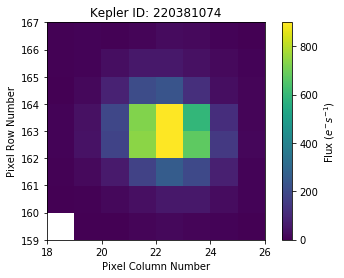

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

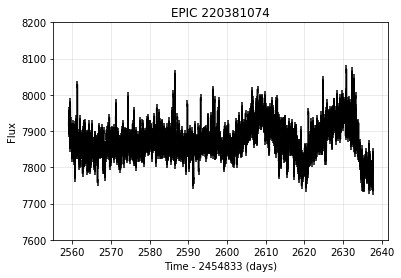

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all') 

lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `lightkurve.injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2.e-7 [units?]

In [4]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()

Let's plot the model by itself:

Text(0,0.5,'Flux')

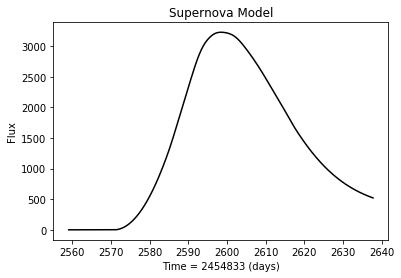

In [5]:
model_sn_eval = model.evaluate(lc.time)
plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

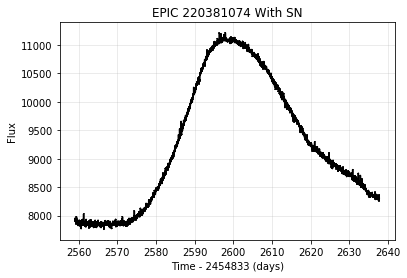

In [6]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

Now let's use the `.recover` method to recover the injected supernova.

In [7]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [8]:
%%time
result = inj.recover(lcinj, 'Supernova', x0)

CPU times: user 1min 50s, sys: 17 s, total: 2min 7s
Wall time: 2min 18s


In [9]:
result

array([  2.59958825e+03,   4.34691906e-01,   1.90462752e-07,
         7.98950036e+03])

In [11]:
T0_f, z_f, amplitude_f, background_f = result

Create a new SupernovaModel object with the fitted parameters:

In [12]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

Text(0,0.5,'Flux')

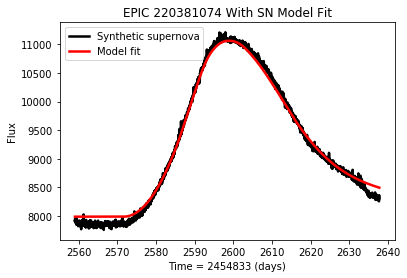

In [13]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

Looks like a pretty good fit. yay